# Neural Networks Experiments

## Students: <br>
Tomás Rojas <br>
Matías Montagna <br>
Alonso Utreras

## The objective of this notebook is to show the results from different models, including different inputs, but trying to get the same output.

In [ ]:
!wget https://github.com/AlasAltum/Proyecto_ML_MP2.5/blob/master/data/cleaned-data/temuco_cleaned_data.csv

--2020-08-18 02:16:39--  https://github.com/AlasAltum/Proyecto_ML_MP2.5/blob/master/data/cleaned-data/temuco_cleaned_data.csv
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘temuco_cleaned_data.csv’

temuco_cleaned_data     [  <=>               ]  75.37K   212KB/s    in 0.4s    

2020-08-18 02:16:40 (212 KB/s) - ‘temuco_cleaned_data.csv’ saved [77183]



In [3]:
%%file log_info.py

"""Log Info. Stores info from a model to record it."""


class LogInfo():

    def __init__(self, model, logging_name):
        self.model = model
        self.training_info = []
        self.model_loss = {'train': 0, 'test': 0}
        self.training_set_size = 0
        self.training_time = 0.
        self.testing_set_size = 0
        self.commentary = ""
        self.logging_name = logging_name

    def set_comment(self, commentary):
        self.commentary = commentary

    def add_info(self, info):
        self.commentary += info + '\n'

    def add_model_loss(self, t_set, loss):
        self.model_loss[t_set] = loss

    def set_train_test_size(self, x_train, x_test):
        try:
            self.training_set_size = x_train.shape
            self.testing_set_size = x_test.shape

        except:
            self.training_set_size = x_train
            self.testing_set_size = x_test

    def set_training_time(self, time):
        self.training_time = time

    def export_info(self):
        with open(f"./{self.logging_name}.log", 'w') as f:
            print(f'{str(self)}', file=f)

    def __str__(self):
        return f"""Model Name: {self.model.name}
        Loss: {self.model_loss}
        Training Set Size: {self.training_set_size}
        Training time: {self.training_time}
        Testing Set Size: {self.testing_set_size}
        ------------------------------------------
        Additional Comments:
        {self.commentary}
        """



Overwriting log_info.py


In [34]:
import pandas as pd
import torch
import torch.optim as optim
from torch import nn
import numpy as np
from sklearn.model_selection import train_test_split
import log_info as log

# Get data
all_data = pd.read_csv(r"./temuco_cleaned_data.csv", delimiter=',')

all_data = all_data.dropna()

all_data["mp_25"] = all_data["mp_2,5"]
all_data = all_data.drop(["mp_2,5"], axis=1)

X = all_data[all_data.columns[2:-1]]

# X = X[['direccion_viento','humedad_relativa', 'precipitaciones','presion_atmosferica','temperatura_ambiente','velocidad_viento']]

X = X[['direccion_viento', 'humedad_relativa', 'precipitaciones', 'presion_atmosferica', 'temperatura_ambiente' ,'velocidad_viento']]

Y = all_data[all_data.columns[-1]]


In [35]:
X.head()

,direccion_viento,humedad_relativa,precipitaciones,presion_atmosferica,temperatura_ambiente,velocidad_viento
0,264.0,71.0,0.0,1001.0,11.9,1.4
1,263.0,74.0,0.0,1001.0,11.2,1.4
2,288.0,77.0,0.0,1000.0,10.6,1.0
3,273.0,81.0,0.0,1000.0,10.1,1.2
4,263.0,83.0,0.0,1001.0,10.0,1.2


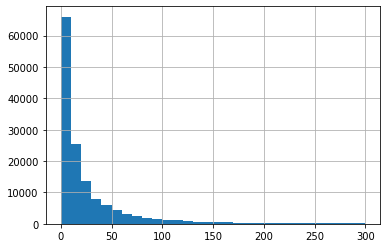

In [36]:
datita = all_data[all_data['mp_25'] < 300]
datita = datita[datita['mp_25'] > 0]

X = datita[datita.columns[2:-1]]
Y = datita[datita.columns[-1]]
Y.hist(bins=30)

### Dividing data into train, test and validation sets
We chose a train size of 70% of all data, while 15% corresponds to test and 15% to validation data.

In [37]:
import torch.utils.data as data_utils

_X_train, _X_test, _y_train, _y_test = train_test_split(X, Y, test_size=0.15, random_state=42)


In [38]:
from sklearn.preprocessing import MinMaxScaler

x_train_np = np.asarray(_X_train.values)
y_train_np = np.asarray(_y_train.values)

x_test_np = np.asarray(_X_test.values)
y_test_np = np.asarray(_y_test.values)

scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_normalized = scaler.fit_transform(x_train_np)
y_train_normalized = scaler.fit_transform(y_train_np.reshape(-1, 1))

X_test_normalized = scaler.fit_transform(x_test_np)
y_test_normalized = scaler.fit_transform(y_test_np.reshape(-1, 1))

# train = data_utils.TensorDataset(torch.Tensor(np.array(_X_train)), torch.Tensor(np.array(_y_train)))
# train_loader = data_utils.DataLoader(train, batch_size = 24, shuffle = True)

# test = data_utils.TensorDataset(torch.Tensor(np.array(_X_test)), torch.Tensor(np.array(_y_val)))
# test_loader = data_utils.DataLoader(train, batch_size = 24, shuffle = True)


# train_data_normalized = torch.FloatTensor(X_train).view(-1)

In [39]:
train_dataloader = data_utils.TensorDataset(torch.Tensor(np.array(_X_train)), torch.Tensor(np.array(_y_train)))
train_loader = data_utils.DataLoader(train_dataloader, batch_size = 24, shuffle = False)


test_dataloader = data_utils.TensorDataset(torch.Tensor(np.array(X_test_normalized)), torch.Tensor(np.array(y_test_normalized)))
test_loader = data_utils.DataLoader(test_dataloader, batch_size = 24, shuffle = False)

### Setting device to work with. Use cuda if available.

In [40]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Classes for training our models:

## First model, which is a simple ff NN using just date.
Simple feedforward NN
Input: Date

In [41]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleDoubleModel(nn.Module):
    """ Simple feedforward network of two fully connected layers"""
    def __init__(self, input_size, hidden_size, output_size=1, model_name='Three Fully Connected Layers'):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.fc3 = nn.Linear(output_size, output_size)
        self.dropout = nn.Dropout(0.25)
        self.logsigmoid = nn.LogSigmoid()

        self.name = model_name

    def forward(self, x):
        x = F.relu(self.dropout(self.fc1(x)))
        x = self.logsigmoid(self.dropout(self.fc2(x)))
        x = self.fc3(x)

        return x



# Setting model to use and its name
model_name = "Three fully connected models"
# model_1_temp_pm = LSTMModel(6, 128, 3, 1, model_name)

model = SimpleDoubleModel(6, 128, 1, "Three fully connected")
loss_1 = nn.MSELoss(reduction = 'sum')

# Setting model, loss and optimizer
loss = loss_1.to(device)
optimizer = optim.Adam(model.parameters())

# Setting logger
Logger = log.LogInfo(
    model=model,
    logging_name=model_name
    )
Logger.add_info(model_name)

# Hyperparamters
n_epochs = 7

## Training function

In [42]:
import time
from torch.autograd import Variable


def init_weights(model):
    # Inicializamos los pesos como aleatorios
    for name, param in model.named_parameters():
        nn.init.normal_(param.data, mean=0, std=0.1) 

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def train(model, train_loader, optimizer, loss_function, epochs):
    model.train()
    total_loss = 0

    for i in range(epochs):
        # each epoch
        epoch_loss = 0
        best_test_loss = float('inf')
        # /_input.size()[1], 1 , self.input_size)
        # x_i => (1 , self.input_size)
        # x_i.size[1]

        for x_i, y_i in train_loader:

            # x_i = x_i.view(-1, 6, 1)
            x_i, y_i = Variable(x_i), Variable(y_i)
            # Each batch
            y_i = y_i.double()

            optimizer.zero_grad()
            y_pred = model(x_i.double()).double()
      
            y_pred = y_pred.view(-1, y_pred.shape[-1])
            y_i = y_i.view(y_pred.shape)

            loss = loss_function(y_pred, y_i)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()

        # Save results from the best trained model
        if epoch_loss < best_test_loss:
            best_test_loss = epoch_loss
            torch.save(model.state_dict(), '{}.pt'.format(model.name))
            
        total_loss += epoch_loss
        print(f'epoch: {i} loss: {epoch_loss:10.8f}')

    return total_loss

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def test(model, test_loader, loss_function):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for x_i, y_i in test_loader:
            # predict data using the given model
            y_pred = model(x_i.double())
            # Compute loss
                  
            y_pred = y_pred.view(-1, y_pred.shape[-1])
            y_i = y_i.view(y_pred.shape)
            
            total_loss += loss_function(y_pred, y_i).item()

    print(total_loss)
    return total_loss

def load_best_model(model):
    return model.load_state_dict(torch.load(f'{model.name}.pt'))

### Execute Training and Testing:

In [43]:
# Execute training
def execute_training(model, train_loader, test_loader, optimizer, loss_function, logger, n_epochs=5):
    # Train

    start_time = time.time()
    train_loss = train(model, train_loader, optimizer, loss_function, n_epochs)
    end_time = time.time();
    train_time = end_time - start_time

    print(f'Training time = {train_time}')
    print(f'Train Loss: {train_loss}')

    # Test
    start_time = time.time()

    test_loss = test(model,  test_loader, loss_function)
    end_time = time.time()
    test_time = end_time - start_time 

    print(f'\t Val. Loss: {test_loss:.3f}')

    logger.model_loss['train'] = train_loss
    logger.model_loss['test'] = test_loss
    logger.set_train_test_size(len(train_loader), len(test_loader))
    logger.set_training_time(train_time)
    # logger.set_epochs(n_epochs)
    # logger.set_optimizer(optimizer)



In [44]:
# Clean CUDA RAM
# torch.cuda.empty_cache()

## Train and Test model 

### Normalizing train data:
We read here https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/
that it is important to normalize data when working with time series. 


In [45]:
print(f'The current model contains {count_parameters(model)} trainable parameters.')     
model.apply(init_weights)
model = model.double()


execute_training(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    loss_function=loss,
    logger=Logger,
    n_epochs=n_epochs
    )

The current model contains 1027 trainable parameters.
epoch: 0 loss: 205016658.41413894
epoch: 1 loss: 189085353.58082765
epoch: 2 loss: 184556604.63164926
epoch: 3 loss: 180283561.89349756
epoch: 4 loss: 177727850.05476034
epoch: 5 loss: 175736484.87561488
epoch: 6 loss: 174692697.67744538
Training time = 45.72111678123474
Train Loss: 1287099211.127934
27748781.45547806
	 Val. Loss: 27748781.455


In [46]:
load_best_model(model)

# Export info to a logger to store results
Logger.export_info()

### Plotting predicted data vs real data using testing set

In [47]:

X_train = torch.from_numpy(np.array(_X_train))
y_train = torch.from_numpy(np.array(_y_train))

y_train_cpu = y_train.cpu().detach().numpy()

y_pred = model(X_train)
y_pred_cpu = y_pred.cpu().detach().numpy()


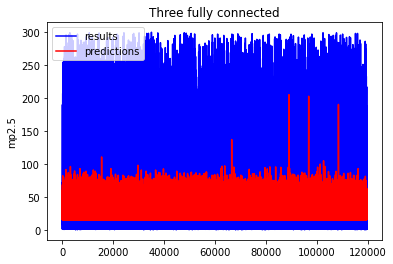

In [48]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()


plt.plot(y_train_cpu, "b-", label="results")
plt.plot(y_pred_cpu, "r-", label="predictions")

plt.ylabel("mp2.5")
plt.title(model.name)
ax.legend()

# plot results and store it in results directory
plt.savefig(fname=f'./{model.name}.png')
plt.show()

In [49]:
from sklearn.metrics import r2_score

r2_obtained = r2_score(y_train.cpu().detach().numpy(), y_pred.cpu().detach().numpy())

print(r2_obtained)

Logger.add_info(f"r2 score={r2_obtained}")
Logger.export_info()

0.19889262289408816
